In [6]:
import os
import numpy as np
from gwpy.timeseries import TimeSeries, TimeSeriesDict
import matplotlib.pyplot as plt
from scipy import signal

- Scales by 10^-21
- Crops to first 4 seconds
- Adds 2s of zeros before and after (total duration now 8 seconds)
- Tapers with Tukey window
- Decimates to 4096 Hz

In [7]:
# Load h+ channel
data_dir = 'h(t)'
channel_name = 'GW:HP_X'
timeseries_dict = {}
t0_gps = 1000000000  # GPS start time (corresponds to Sept 2011)


# Load time and strain data
time_data = np.loadtxt(os.path.join(data_dir, 't.txt'), delimiter=',') # (comma-separated)
data = np.loadtxt(os.path.join(data_dir, 'hp_x.txt'))

# Calculate sample rate
dt = time_data[1] - time_data[0]
sample_rate = 1.0 / dt

ts = TimeSeries(data, sample_rate=sample_rate, t0=t0_gps, name=channel_name, unit='strain')

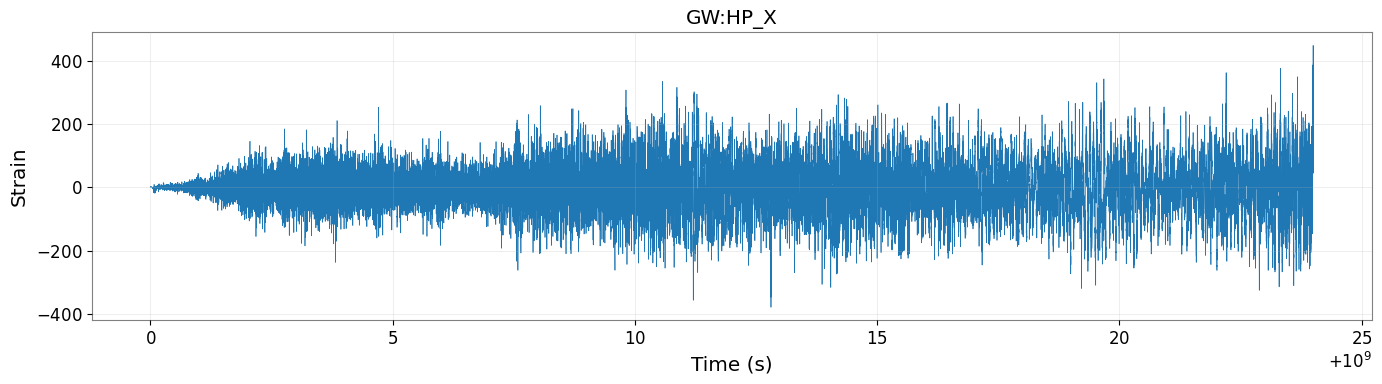

In [8]:
plt.figure(figsize=(14, 4))
plt.plot(ts.times.value, ts.value, linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title(channel_name)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Preprocessing steps
ts_processed = ts * 1e-23 # scale
ts_processed = ts_processed.crop(t0_gps, t0_gps + 4.0) # crop to first 4 seconds

# Add 2 seconds of zeros before and after the signal
sample_rate_original = ts_processed.sample_rate.value
n_zeros = int(2.0 * sample_rate_original)  # 2 seconds of samples

# Create zero-padded data
padded_data = np.concatenate([np.zeros(n_zeros), ts_processed.value, np.zeros(n_zeros)])

# Create new TimeSeries with padded data (adjusting t0 to account for the 2s prepended)
ts_processed = TimeSeries(padded_data, sample_rate=sample_rate_original, 
                          t0=t0_gps - 2.0, name=channel_name, unit='strain')

# Apply taper to the entire padded signal
ts_processed = ts_processed * signal.windows.tukey(len(ts_processed), alpha=0.1)

# Decimate to 4096 Hz
decimation_factor = int(ts_processed.sample_rate.value / 4096)
data_decimated = signal.decimate(ts_processed.value, decimation_factor, ftype='iir')
ts_processed = TimeSeries(data_decimated, sample_rate=4096, t0=t0_gps - 2.0, name=channel_name, unit='strain')

# To write GWF format, first install: conda install -c conda-forge python-ldas-tools-framecpp            
ts_processed.write('Frame.gwf', format='gwf')
print(f"Written {len(ts_processed)} samples at {ts_processed.sample_rate.value} Hz to Frame.gwf")
print(f"Total duration: {ts_processed.duration.value} seconds (2s zeros + 4s signal + 2s zeros)")

Written 39996 samples at 4096.0 Hz to Frame.gwf
Total duration: 9.7646484375 seconds (2s zeros + 4s signal + 2s zeros)


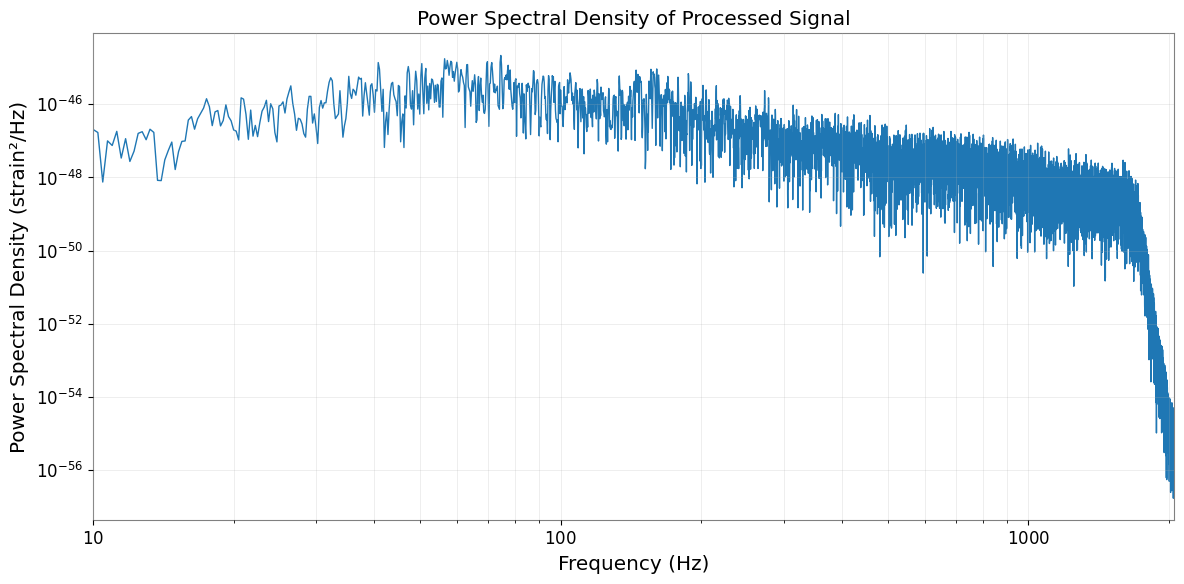

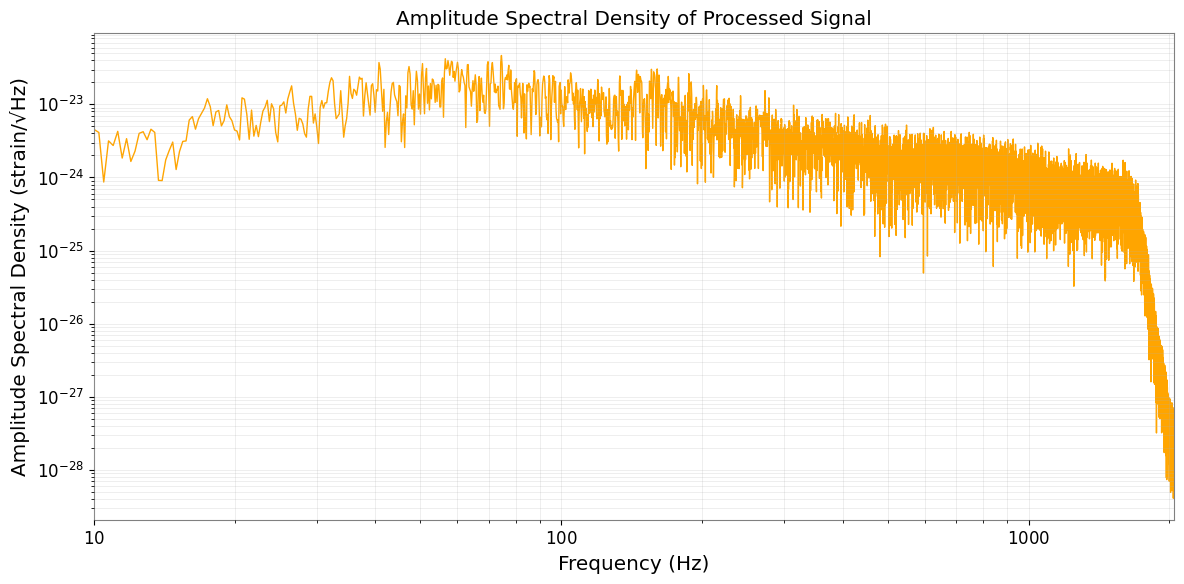

PSD calculated with 4s FFT length and 2s overlap
Frequency resolution: 0.25 Hz


In [11]:
# Calculate PSD (Power Spectral Density)
# Using Welch's method with appropriate parameters for GW data
fftlength = 4  # FFT length in seconds
overlap = 2    # Overlap in seconds

psd = ts_processed.psd(fftlength=fftlength, overlap=overlap)

# Plot PSD
plt.figure(figsize=(12, 6))
plt.loglog(psd.frequencies.value, psd.value, linewidth=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (strain²/Hz)')
plt.title('Power Spectral Density of Processed Signal')
plt.grid(True, alpha=0.3, which='both')
plt.xlim(10, 2048)  # Up to Nyquist frequency (half of 4096 Hz)
plt.tight_layout()
plt.show()

# Also calculate and plot ASD (Amplitude Spectral Density)
asd = ts_processed.asd(fftlength=fftlength, overlap=overlap)

plt.figure(figsize=(12, 6))
plt.loglog(asd.frequencies.value, asd.value, linewidth=1, color='orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectral Density (strain/√Hz)')
plt.title('Amplitude Spectral Density of Processed Signal')
plt.grid(True, alpha=0.3, which='both')
plt.xlim(10, 2048)
plt.tight_layout()
plt.show()

print(f"PSD calculated with {fftlength}s FFT length and {overlap}s overlap")
print(f"Frequency resolution: {psd.df.value} Hz")

# Save PSD and ASD to .dat files
np.savetxt('psd.dat', np.column_stack([psd.frequencies.value, psd.value]), 
           header='Frequency (Hz), PSD (strain^2/Hz)', delimiter=',')
np.savetxt('asd.dat', np.column_stack([asd.frequencies.value, asd.value]), 
           header='Frequency (Hz), ASD (strain/sqrt(Hz))', delimiter=',')